Unzipping Dataset

In [ ]:
import pickle
import numpy as np
import pandas as pd
import os

directory = '../../affect-recognition/data/data.zip'
output_directory = '../../affect-recognition/data/'

os.listdir(output_directory)

import zipfile
with zipfile.ZipFile(directory, 'r') as zip_ref:
    zip_ref.extractall(output_directory)

Plotting Individual Data

In [1]:
import pickle
import os
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from ecgdetectors import Detectors
from scipy import signal
from scipy.stats import skew,kurtosis,iqr
import pickle
from peak_valley import compute_peak_valley
from respiration_feature import rip_cycle_feature_computation
filelists = ['../data/PPG_FieldStudy/'+a+'/'+a+'.pkl' for a in os.listdir('../data/PPG_FieldStudy/') if a[-1] not in ['s','f']]

In [ ]:
%matplotlib notebook
def get_ecg_rr(ecg_data):
    detectors = Detectors(700)
    rpeaks = detectors.hamilton_detector(ecg_data[:,1])
    ecg_r_ts = ecg_data[np.array(rpeaks),0]
    ecg_rr_ts = ecg_r_ts[1:]
    ecg_rr_sample = np.diff(ecg_r_ts)
    ecg_rr = pd.DataFrame(np.vstack([ecg_rr_ts,ecg_rr_sample]).T,columns=['time','rr'])
    ecg_rr['timestamp'] = ecg_rr['time'].apply(lambda a:datetime.utcfromtimestamp(a))
    return ecg_rr

def bandpass_filter(data,Fs=64,fil_type='ppg'):
    X0 = data[:,1]
    X1 = signal.detrend(X0,axis=0,type='constant')
    X2 = np.zeros((np.shape(X1)[0],data.shape[1]))
    nyq = Fs/2
    b = signal.firls(219,np.array([0,0.5,0.7,3.5,4,nyq]),
                              np.array([0,0,1,1,0,0]),np.array([10,1,1]),fs=nyq*2)
    a = [1]
    X2[:,0] = data[:,0]
    X2[:,1] = signal.filtfilt(b, a, X1)
    return X2

def bandpass_filter_respiration(data,Fs=700,fil_type='ppg'):
    X0 = data[:,1]
    X1 = signal.detrend(X0,axis=0,type='constant')
    X2 = np.zeros((np.shape(X1)[0],data.shape[1]))
    nyq = Fs/2
    b = signal.firls(219,np.array([0,0.03,0.05,2,2.5,nyq]),
                              np.array([0,0,1,1,0,0]),np.array([10,1,1]),fs=nyq*2)
    a = [1]
    X2[:,0] = data[:,0]
    X2[:,1] = signal.filtfilt(b, a, X1)
    return X2

def get_quality_features(ppg_data,ppg_fs=64,window_size=2.5):
    ppg_data_final = []
    n = int(ppg_fs*window_size/2)
    for i in range(n,ppg_data.shape[0]-n,1):
        tmp = []
        tmp.append(ppg_data[i,0])
        tmp.append(ppg_data[i,1])
        sample = ppg_data[(i-n):(i+n),1]
        tmp.extend([-1]*4)
#         tmp.append(skew(sample))
#         tmp.append(kurtosis(sample))
#         tmp.append(iqr(sample))
#         f,pxx = signal.welch(sample,fs=ppg_fs,nperseg=len(sample)//2,nfft=10000,axis=0)
#         tmp.append(np.trapz(pxx[np.where((f>=.8)&(f<=2.5))[0]])/np.trapz(pxx))
        ppg_data_final.append(np.array(tmp))
    return np.array(ppg_data_final)


def save_participant_data(filename,ecg_fs = 700,ppg_fs = 64,acc_fs=32,window_size=8,activity_fs=4):
    data = pickle.load(open(filename,'rb'),encoding='latin1')
    ppg_data = data['signal']['wrist']['BVP']
    acc_data = data['signal']['wrist']['ACC']/64
    activity_data = data['activity']
    label_data = data['label']
#     plt.plot(label_data)
#     plt.show()
#     print(data['activity'].shape,acc_data.shape,acc_data.shape[0]/data['activity'].shape[0],data['label'].shape)
#     print(data['signal']['wrist']['ACC'].shape[0]*2,ppg_data.shape)
    ecg_data = data['signal']['chest']['ECG']
    respiration_data = data['signal']['chest']['Resp']
    total_seconds = ppg_data.shape[0]/ppg_fs
    start_ts = datetime.utcnow().timestamp()
    ecg_ts = start_ts + np.arange(0,total_seconds,1/ecg_fs)
    acc_ts = start_ts + np.arange(0,total_seconds,1/acc_fs)
    label_ts = start_ts + np.arange(0,label_data.shape[0]*2,1/.5) + 4
    print(label_data.shape,label_ts.shape)
    label_data = np.concatenate([label_ts.reshape(-1,1),label_data.reshape(-1,1)],axis=1)
    print(label_data.shape,label_ts.shape,'after')
    activity_ts = start_ts + np.arange(0,total_seconds,1/activity_fs)
    activity_data = np.concatenate([activity_ts.reshape(-1,1),activity_data],axis=1)
    acc_data = np.concatenate([acc_ts.reshape(-1,1),acc_data],axis=1)
    respiration_ts = ecg_ts
    respiration_data = np.vstack([respiration_ts,respiration_data.reshape(-1)]).T
    ecg_data = np.vstack([ecg_ts,ecg_data.reshape(-1)]).T
    print(ecg_data.shape[0]/ecg_fs,respiration_data.shape[0]/ecg_fs,
          acc_data.shape[0]/acc_fs,activity_data.shape[0]/activity_fs,
          label_data.shape[0]*2)
    ecg_rr1 = get_ecg_rr(ecg_data)
    ecg_rr = ecg_rr1.values
#     plt.figure(figsize=(10,5))
#     plt.plot(ecg_rr[:,0],60/ecg_rr[:,1])
#     plt.plot(activity_data[:,0],activity_data[:,1])
#     plt.show()
    ppg_ts = start_ts + np.arange(0,total_seconds,1/ppg_fs)
    ppg_data = np.vstack([ppg_ts,ppg_data.reshape(-1)]).T
    print(len(np.array(range(0,ppg_data.shape[0]-window_size*ppg_fs//2-window_size*ppg_fs//4,window_size*ppg_fs//4))),label_data.shape)
    ppg_data = bandpass_filter(ppg_data,Fs=ppg_fs,fil_type='ppg')
    respiration_data = bandpass_filter_respiration(respiration_data,Fs=ecg_fs,fil_type='ppg')
    respiration_data[:,0] = respiration_data[:,0]*1000
    peak_index,valley_index = compute_peak_valley(respiration_data)
    peak_data = respiration_data[peak_index]
    valley_data = respiration_data[valley_index]
    rip_feature = rip_cycle_feature_computation(peak_data,valley_data)[:,:5]
    rip_feature[:,:2] = rip_feature[:,:2]/1000
    ppg_data = get_quality_features(ppg_data)
#     plt.figure(figsize=(10,5))
# #     plt.plot(ppg_data[:,0],ppg_data[:,1]/np.max(ppg_data[:,1]))
# #     plt.bar(ppg_data[:,0],ppg_data[:,-1],.95/ppg_fs)
# #     plt.show()
    ppg_data = pd.DataFrame(ppg_data,columns=['time','ppg','skew','kurtosis','iqr','relative_power']).dropna().sort_values('time').reset_index(drop=True)
#     plt.figure(figsize=(10,5))
#     plt.hist(ppg_data['relative_power'])
# #     plt.bar(ppg_data[:,0],ppg_data[:,-1],.95/ppg_fs)
#     plt.show()

#     ppg_data['timestamp'] = ppg_data['time'].apply(lambda a:datetime.utcfromtimestamp(a))
    respiration_data[:,0] = respiration_data[:,0]/1000
    all_data = []
    count = 0
    for i in range(0,ppg_data.shape[0]-window_size*ppg_fs//2-window_size*ppg_fs//4,window_size*ppg_fs//4):
        a = ppg_data.loc[i:i+window_size*ppg_fs-1]
#         print(a['time'].min()-a['time'].max())
        b = respiration_data[np.where((respiration_data[:,0]>=a['time'].min())&(respiration_data[:,0]<a['time'].max()))[0],1].reshape(-1,1)
#         print(a.shape,b.shape)
        hr = label_data[count,1]
        count+=1
        if count==label_data.shape[0]:
            continue
        all_data.append([a['time'].min(),a['time'].max(),
                         a[['time','ppg','skew','kurtosis','iqr','relative_power']].sort_values('time').reset_index(drop=True),b,hr])
#     print(len(np.array(range(0,ppg_data.shape[0]-window_size*ppg_fs//4,window_size*ppg_fs//4))))
    
    ppg_windows = pd.DataFrame(all_data,columns=['start_time','end_time','data','respiration','hr'])
    ppg_windows['ecg_rr'] = ppg_windows.apply(lambda a:np.mean(ecg_rr[np.where((ecg_rr[:,0]>=a['start_time'])&(ecg_rr[:,0]<a['end_time']))[0],1]),axis=1)
    ppg_windows['inspiration_duration'] = ppg_windows.apply(lambda a:np.mean(rip_feature[np.where((rip_feature[:,1]>=a['start_time'])&(rip_feature[:,0]<a['end_time']))[0],2]),axis=1)
    ppg_windows['expiration_duration'] = ppg_windows.apply(lambda a:np.mean(rip_feature[np.where((rip_feature[:,1]>=a['start_time'])&(rip_feature[:,0]<a['end_time']))[0],3]),axis=1)
    ppg_windows['respiration_duration'] = ppg_windows.apply(lambda a:np.mean(rip_feature[np.where((rip_feature[:,1]>=a['start_time'])&(rip_feature[:,0]<a['end_time']))[0],4]),axis=1)
    ppg_windows['acc_window'] = ppg_windows.apply(lambda a: acc_data[np.where((acc_data[:,0]>=a['start_time'])&(acc_data[:,0]<a['end_time']))[0],:],axis=1)
    ppg_windows['activity'] = ppg_windows.apply(lambda a: activity_data[np.where((activity_data[:,0]>=a['start_time'])&(activity_data[:,0]<a['end_time']))[0],1],axis=1)
#     ppg_windows['hr'] = ppg_windows.apply(lambda a:np.mean(label_data[np.where((label_data[:,0]>=a['start_time'])&(label_data[:,0]<a['end_time']))[0],1]),axis=1)
    
#     for a in ppg_windows['acc_window'].values:
#         print(a.shape)

    print(ppg_windows.shape,ppg_windows.dropna().shape)
#     plt.figure(figsize=(18,8))
#     plt.plot(ppg_windows['start_time'],ppg_windows['hr'])
#     plt.plot(label_data[:,0],label_data[:,1])
    
#     plt.plot(ppg_windows['start_time'],ppg_windows['respiration_duration'])
#     plt.plot(rip_feature[:,0],rip_feature[:,-1])
#     plt.show()
    print(ppg_windows.shape)
    if not os.path.isdir(output_directory+str(window_size)+'d'):
        os.makedirs(output_directory+str(window_size)+'d')
    final_path = output_directory+str(window_size)+'d/'
    participant_name = filename.split('/')[-1]
    pickle.dump(ppg_windows,open(final_path+participant_name,'wb'))
    
from joblib import Parallel,delayed
output_directory = '../data/'
final = Parallel(n_jobs=20,verbose=2)(delayed(save_participant_data)(f,window_size=8) for f in filelists)
# final = [save_participant_data(f,window_size=8) for f in filelists]
# for filename in filelists:
# filelists[0]
#     print(ecg_rr.head(),ppg_data.head())

In [11]:
filelists = ['../data/8d/'+a for a in os.listdir('../data/8d/') if a[-1] not in ['s','f']]

In [16]:
from collections import Counter
import seaborn as sns
from scipy.stats import mode
data_col = []
activity_dict = {0:'No Label',
                1:'Sitting',
                2:'Stairs',
                3:'Soccer',
                4:'Cycling',
                5:'Driving',
                6:'Lunch',
                7:'Walking',
                8:'Working'}
activity_dict1 = {'No Label':-1,
                'Sitting':0,
                'Stairs':1,
                'Soccer':2,
                'Cycling':3,
                'Driving':4,
                'Lunch':-1,
                'Walking':5,
                'Working':-1}

X_acl = []
X_ppg = []
y_hr = []
y_participant = []
y_activity = []

from sklearn.preprocessing import MinMaxScaler

for i in range(len(filelists)):
    data = pickle.load(open(filelists[i],'rb'))
#     data['acc_window'] = data['acc_window'].apply(lambda a:a)
    data['shape'] = data['data'].apply(lambda a:a.shape[0])
    data = data[data['shape']==512]
    data['ppg_window'] = data['data'].apply(lambda a:a.sort_values('time').reset_index(drop=True)['ppg'].values.reshape(512,1)[np.arange(0,512,2),:])
    data['shape'] = data['ppg_window'].apply(lambda a:a.shape[0])
    data = data[data['shape']==256]
    data['shape'] = data['acc_window'].apply(lambda a:a.shape[0])
    data = data[data['shape']==256]
    data['ppg_window'] = data['ppg_window'].apply(lambda a:MinMaxScaler().fit_transform(a.reshape(256,1)))
    data['ppg_window'] = data['ppg_window'].apply(lambda a:a.reshape(1,256,1))
    data['acc_window'] = data['acc_window'].apply(lambda a:a.reshape(1,256,4))    
#     print(Counter(data['shape'].values))
    data['activity'] = data['activity'].apply(lambda a:mode(list(a))[0][0])
    data['activity_label'] = data['activity'].apply(lambda a:activity_dict[a])
#     data['activity'] = data['activity_label'].apply(lambda a:activity_dict1[a])
    data = data[data.activity>0]
    X_acl.extend(list(data['acc_window'].values))
    X_ppg.extend(list(data['ppg_window'].values))
    y_hr.extend(list(data['hr'].values))
    y_participant.extend([i]*data.shape[0])
    y_activity.extend(list(data['activity_label'].values))


In [17]:
X_acl = np.concatenate(X_acl)[:,:,1:]
X_ppg = np.concatenate(X_ppg)
y_hr = np.array(y_hr)
y_participant = np.array(y_participant)
y_activity = np.array(y_activity)
X = np.concatenate([X_ppg,X_acl],axis=2)

In [18]:
X.shape,X_acl.shape,X_ppg.shape,y_hr.shape,y_participant.shape,y_activity.shape

((47206, 256, 4),
 (47206, 256, 3),
 (47206, 256, 1),
 (47206,),
 (47206,),
 (47206,))

In [19]:
pickle.dump([X,y_hr,y_participant,y_activity],open('../data/heart_rate_tabular_data_ppg_dalia.p','wb'))

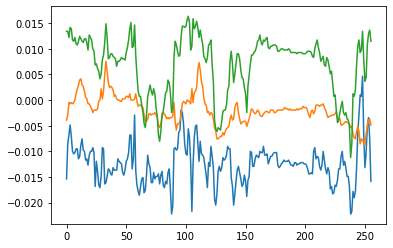

In [39]:
plt.figure()
plt.plot(X[0][:,1:])
plt.show()

/home/azim/miniconda3/envs/test1/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/azim/miniconda3/envs/test1/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 39.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/azim/miniconda3/envs/test1/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 69.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/azim/miniconda3/envs/test1/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 32.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/azim/miniconda3/envs/test1

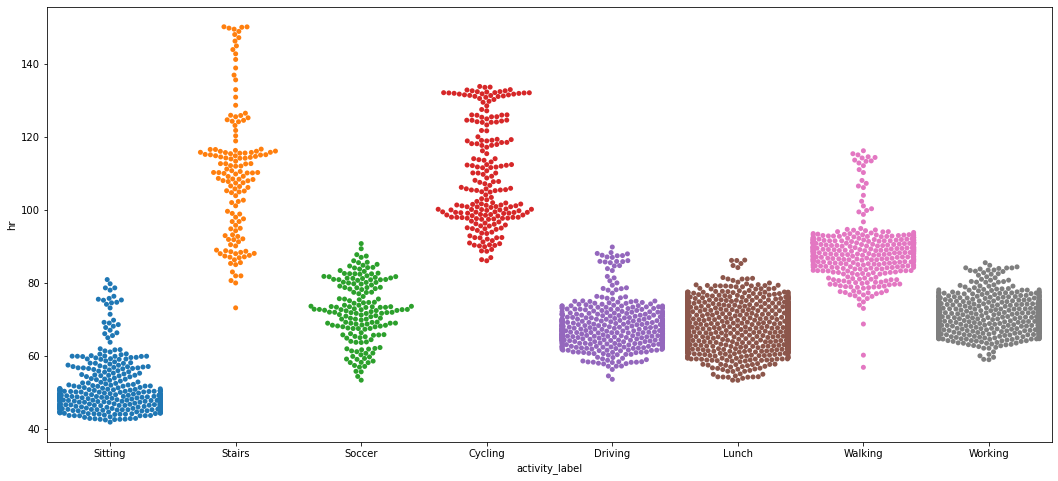

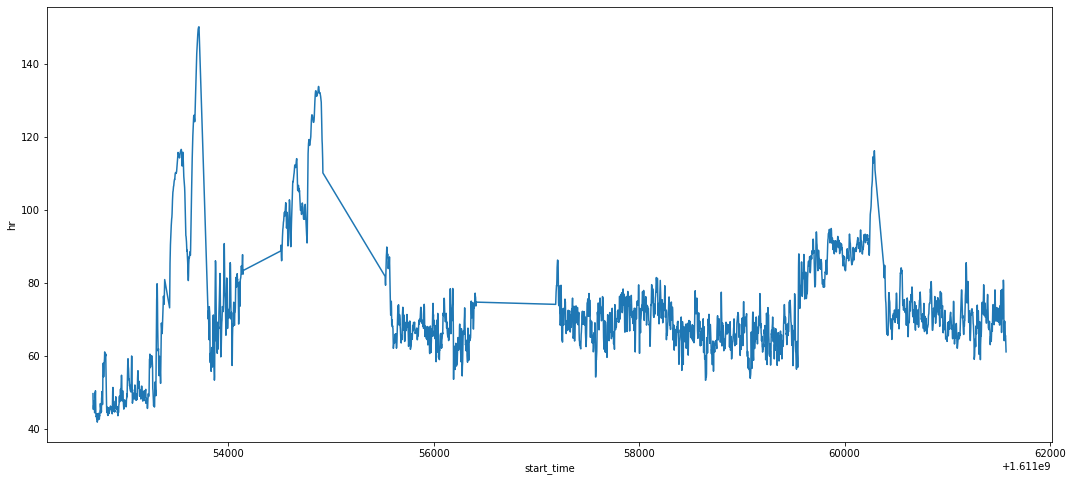

In [11]:
plt.figure(figsize=(18,8))
sns.swarmplot(x='activity_label',y='hr',data=data)
plt.show()
plt.figure(figsize=(18,8))
sns.lineplot(x='start_time',y='hr',data=data)
plt.show()
#     plt.plot(data['start_time'],data['hr'])
#     plt.plot(data['start_time'],60/data['ecg_rr'])
    
# #     plt.plot(ppg_windows['start_time'],ppg_windows['respiration_duration'])
# #     plt.plot(rip_feature[:,0],rip_feature[:,-1])
#     plt.show()
#     plt.hist(data['data'].loc[0]['relative_power'])
#     plt.show()